# Notebook TESTING lazyloading of AMPS domain 02 RAW output 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

import gcsfs
from tqdm import tqdm
import fsspec

xr.set_options(display_style="html");
# xr.show_versions()

In [2]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} wrf-python netCDF4

import wrf
from netCDF4 import Dataset

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::esmf==8.0.1=mpi_mpich_h3cbecb6_102
  - conda-forge/noarch::xesmf==0.5.1=pyhd8ed1ab_0
  - conda-forge/linux-64::esmpy==8.0.1=mpi_mpich_py38h6f0bf2d_102
done

## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - netcdf4
    - wrf-python


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    esmf-8.1.0                 |mpi_mpich_h224d73f_100        28.4 MB  conda-forge
    esmpy-8.1.0                |mpi_mpich_py38h7f78e9f_100         173 KB  conda-forge
    netcdf4-1.5.6              |nompi_py38h1cdf482_100         555 KB  conda-forge
    openssl-1.1.1j             |       h7f98852_0         2.1 MB  conda-forge
    wrf-python-1.3.2.5         |   py38h0e9072a_0         5.1 

# Dask Startup

In [3]:
# xr.show_versions()

In [4]:
## A chunk of code to start dask cluster
from dask.distributed import Client, progress
from dask_gateway import Gateway
gateway = Gateway()

In [5]:
if gateway.list_clusters():
    cluster_name = gateway.list_clusters()[0].name
    cluster = gateway.connect(cluster_name)
    print(f"Connecting to pre-existing cluster with {len(cluster.scheduler_info['workers'])} workers.")
else:
    cluster = gateway.new_cluster() 
    cluster.adapt(minimum=2, maximum=12)
    print("Starting up and connecting to new cluster.")

cluster
# cluster.scheduler_info

Starting up and connecting to new cluster.


In [6]:
client = cluster.get_client()
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.b8e2847563dc49e7bcb8750a85186020 Dashboard: /services/dask-gateway/clusters/prod.b8e2847563dc49e7bcb8750a85186020/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### setup runtime parameters

In [7]:
gcsdir = 'gs://ldeo-glaciology'
ampsdir = 'AMPS'
amps_ver = 'WRF_24'
domain = 'domain_02'
filepattern = 'wrfout_d02_20191231*'


In [8]:
# pattern = 'gs://ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-20161225*'
pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)
print(pattern)

gs://ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_20191231*


### list the netcdf files

In [9]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)

In [10]:
NCs = fs.glob(pattern)
print(f"Total of {len(NCs)} wrf files.\n")
print(NCs[0])

Total of 8 wrf files.

ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f003.nc


In [11]:
NCs_urls = ['https://storage.googleapis.com/' + x + '#mode=bytes' for x in NCs]
print(NCs_urls)

['https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f003.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f006.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f009.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f012.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123112_f003.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123112_f006.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123112_f009.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123112_f012.nc#mode=bytes']


### wrf-python

In [12]:
nc = Dataset(NCs_urls[0])

In [13]:
t2 = wrf.getvar(nc, 'T2', timeidx=wrf.ALL_TIMES)
# t2 = wrf.getvar(nc, 'T2', timeidx=2) # extract 3rd time instance (t=2) - slow....
t2

<xarray.DataArray 'T2' (south_north: 786, west_east: 834)>
array([[276.32684, 276.3126 , 276.29028, ..., 280.02762, 280.0299 ,
        280.03668],
       [276.28687, 276.27173, 276.25058, ..., 280.06332, 280.05975,
        280.0657 ],
       [276.24695, 276.23138, 276.21048, ..., 280.10034, 280.0934 ,
        280.0957 ],
       ...,
       [282.44852, 282.41086, 282.36856, ..., 282.26367, 282.27908,
        282.29144],
       [282.48935, 282.45438, 282.4154 , ..., 282.22162, 282.23602,
        282.24896],
       [282.52267, 282.48822, 282.45117, ..., 282.18826, 282.1993 ,
        282.20947]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 49.78 49.71 ... -136.2 -136.2
    XLAT     (south_north, west_east) float32 -50.69 -50.74 ... -48.16 -48.12
    XTIME    float32 180.0
    Time     datetime64[ns] 2019-12-31T03:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   PolarStereographic(stand_lon=180.0, moad_cen_lat=-87.399993...

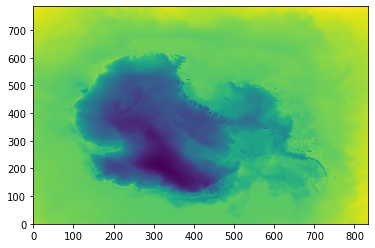

In [22]:
plt.pcolor(wrf.to_np(t2))

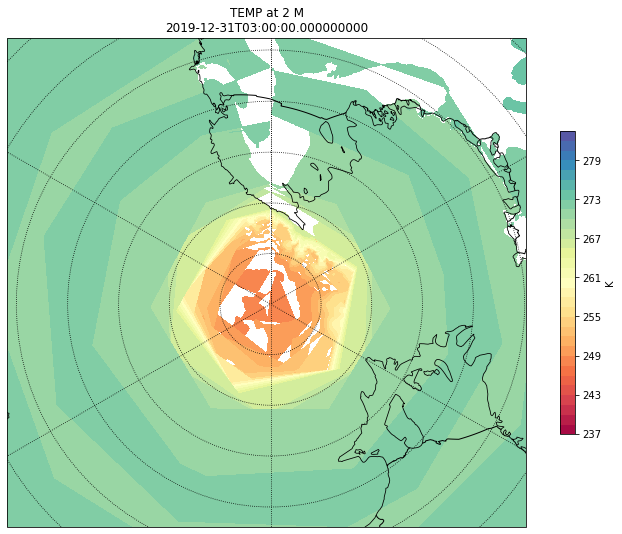

In [30]:
import matplotlib
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import cartopy.feature as cfe
import cartopy.crs as crs

# select one time instance if you have retrieved ALL_TIMES
# t2 = t2.isel(Time=1)

# Get the latitude and longitude points (use original data, rather than any processed data)
lats, lons = wrf.latlon_coords(t2)

# Get the cartopy mapping object (use original data, rather than any processed data)
cart_proj = wrf.get_cartopy(t2)

# Create a figure
fig = plt.figure(figsize=(12,9))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Add coastlines
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(cfe.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', 
                                       '50m', linewidth=1.0, edgecolor='k', facecolor='none') )

# Plot contours
plt.contourf(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(t2), 30, 
                transform=crs.PlateCarree(), cmap=get_cmap("Spectral"))

# Add a color bar
cbar = plt.colorbar(ax=ax, shrink=.62)
cbar.set_label(t2.units)

# Set the map limits.  Not really necessary, but used for demonstration.
ax.set_xlim(np.array(wrf.cartopy_xlim(t2))/2)
ax.set_ylim(np.array(wrf.cartopy_ylim(t2))/2)

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title(t2.description+'\n'+str(t2.Time.values))

print('')

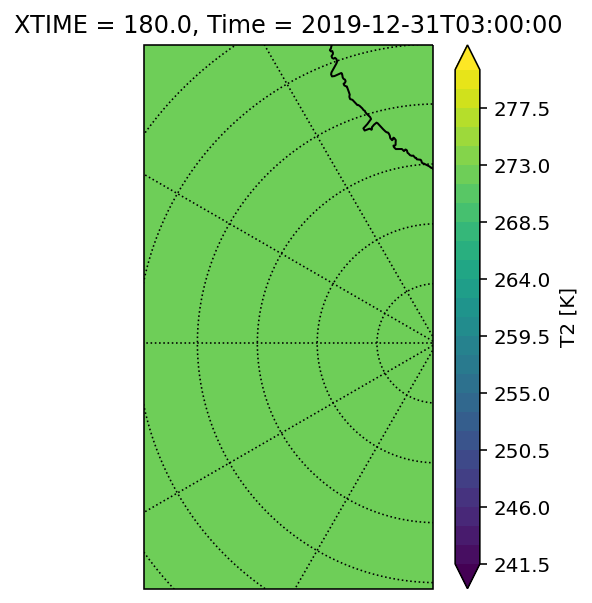

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle

In [31]:
## THIS NEEDS cartopy 0.18 but can't install it for some reason...

import shapely.geometry as sgeom
import cartopy.crs as ccrs


box = sgeom.box(minx=35, maxx=175, miny=-80, maxy=-88.5)
x0, y0, x1, y1 = box.bounds
myproj = ccrs.SouthPolarStereo(central_longitude=180)
# myproj = ccrs.Orthographic()

plt.figure(figsize=(4, 5), facecolor='white', dpi=144)
ax = plt.axes(projection=myproj)
ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())  
ax.coastlines('50m')
# ax.stock_img()

# pcm1 = ax.pcolormesh(da.west_east, ds.south_north, da.mean(dim='Time'),\
#                     vmin=268, vmax=275,\
#                     transform=ccrs.PlateCarree())#, cmap=plt.get_cmap("BuPu")
## Alternative
kwargs = dict(ax=ax,
              x='west_east', y='south_north',
              transform=ccrs.PlateCarree())#, vmin=270, vmax=275)
pcm1 = t2.plot.contourf(levels=31, robust=True,  **kwargs)


# # c = plt.colorbar(orientation='vertical', shrink=0.4, pad=0.10)
# cb1 = plt.colorbar(pcm1, ax=ax, label=r'Surface Heat Flux $[W {m^{-2}}]$', \
#                    orientation='horizontal', extend='both', \
#                   shrink=0.9, pad=0.01)
# ax.plot(ds.lon[si, sj], ds.lat[si, sj], 'ko', markersize=3, transform=ccrs.PlateCarree())
# ax.plot(ds.lon[ai, aj], ds.lat[ai, aj], 'ko', markersize=3, transform=ccrs.PlateCarree())
# # ax.plot(LON[ssj, ssi], LAT[ssj, ssi], 'ko', markersize=2, transform=ccrs.PlateCarree())

ax.gridlines(color="black", linestyle="dotted")
# plt.suptitle('LH')
# plt.tight_layout()
# plt.savefig('figs/mapplot_TNB_Fsfc_mean.png')
plt.show()

In [16]:
# Use SLP for the example variable
slp = wrf.getvar(nc, "slp")

# Get the cartopy mapping object
cart_proj = wrf.get_cartopy(slp)

print (cart_proj)

# Get the latitude and longitude coordinate.  This is usually needed for plotting.
lats, lons = wrf.latlon_coords(slp)

# Get the geobounds for the SLP variable
bounds = wrf.geo_bounds(slp)

print (bounds)

# Get the geographic boundaries for a subset of the domain
slp_subset = slp[150:250, 150:250]
slp_subset_bounds = wrf.geo_bounds(slp_subset)

print (slp_subset_bounds)

GeoBounds(CoordPair(lat=-50.685890197753906, lon=49.77587890625), CoordPair(lat=-48.12010192871094, lon=-136.17251586914062))
GeoBounds(CoordPair(lat=-65.0716552734375, lon=52.73248291015625), CoordPair(lat=-74.95598602294922, lon=58.016510009765625))


### wrf-python on multiple WRF files

In [33]:
# ncfile = nc.MFDataset(NCs_urls)

# T2 = wrf.combine_files(nc, timeidx="ALL_TIMES")#, method= "join", meta="False")

In [15]:
# from wrf import getvar, ALL_TIMES

# # Creating a simple test list with three timesteps
# wrflist = [Dataset(NCs_urls[0]),
#            Dataset(NCs_urls[1]),
#            Dataset(NCs_urls[2])]

# # Extract the 'P' variable for all times
# p_cat = getvar(wrflist, "T2", timeidx=ALL_TIMES, method="cat")

# print(p_cat)


# Creating a simple test list with three timesteps
wrflist = [Dataset(NCs_urls[0]),
           Dataset(NCs_urls[1]),
           Dataset(NCs_urls[2]),
           Dataset(NCs_urls[3])]

# Extract the 'P' variable for all times
T2_join = wrf.getvar(wrflist, "T2", timeidx=wrf.ALL_TIMES, method='cat')#, method="join", squeeze=False)

In [65]:
print(T2_join)

<xarray.DataArray 'T2' (Time: 4, south_north: 786, west_east: 834)>
array([[[276.32684, 276.3126 , 276.29028, ..., 280.02762, 280.0299 ,
         280.03668],
        [276.28687, 276.27173, 276.25058, ..., 280.06332, 280.05975,
         280.0657 ],
        [276.24695, 276.23138, 276.21048, ..., 280.10034, 280.0934 ,
         280.0957 ],
        ...,
        [282.44852, 282.41086, 282.36856, ..., 282.26367, 282.27908,
         282.29144],
        [282.48935, 282.45438, 282.4154 , ..., 282.22162, 282.23602,
         282.24896],
        [282.52267, 282.48822, 282.45117, ..., 282.18826, 282.1993 ,
         282.20947]],

       [[276.36075, 276.33096, 276.29977, ..., 279.8326 , 279.82126,
         279.8493 ],
        [276.3133 , 276.28357, 276.2546 , ..., 279.85815, 279.854  ,
         279.88864],
        [276.2613 , 276.23315, 276.2064 , ..., 279.8929 , 279.89062,
         279.9276 ],
...
        [282.89743, 282.86072, 282.81885, ..., 282.46994, 282.48047,
         282.4897 ],
        [282.

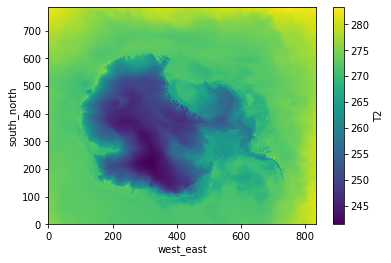

In [66]:
T2_join.mean(dim='Time').plot()

In [59]:
# T2_join.hvplot.image('west_east', 'south_north',
#                     groupby='Time', rasterize=True, dynamic=True, width=800, height=600,
#                     widget_type='scrubber', widget_location='bottom', cmap='RdBu_r')

### convert to DaskArray

In [68]:
da = T2_join.chunk(chunks={'Time':1})
da

<xarray.Dataset>
Dimensions:   (Time: 4, south_north: 786, west_east: 834)
Coordinates:
    XLONG     (south_north, west_east) float32 dask.array<chunksize=(786, 834), meta=np.ndarray>
    XLAT      (south_north, west_east) float32 dask.array<chunksize=(786, 834), meta=np.ndarray>
    XTIME     (Time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * Time      (Time) datetime64[ns] 2019-12-31T03:00:00 ... 2019-12-31T12:00:00
    datetime  (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Data variables:
    T2        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 786, 834), meta=np.ndarray>

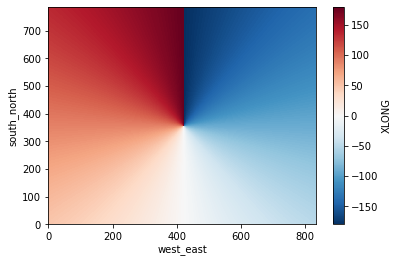

In [55]:
da.XLONG.plot()

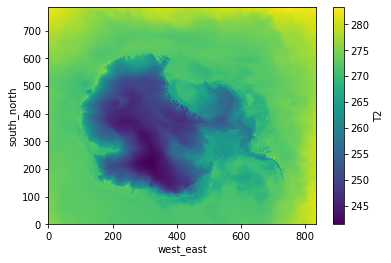

In [56]:
# %%time
da.mean(dim='Time').plot()

In [51]:
%%time
da.mean().compute()

CPU times: user 18.8 ms, sys: 4.02 ms, total: 22.8 ms
Wall time: 13.2 ms


<xarray.DataArray 'T2' ()>
array(268.03592, dtype=float32)

In [53]:
ds = da.to_dataset()
ds

<xarray.Dataset>
Dimensions:   (Time: 4, south_north: 786, west_east: 834)
Coordinates:
    XLONG     (south_north, west_east) float32 dask.array<chunksize=(786, 834), meta=np.ndarray>
    XLAT      (south_north, west_east) float32 dask.array<chunksize=(786, 834), meta=np.ndarray>
    XTIME     (Time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * Time      (Time) datetime64[ns] 2019-12-31T03:00:00 ... 2019-12-31T12:00:00
    datetime  (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Data variables:
    T2        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 786, 834), meta=np.ndarray>

### cartopy and shapely plot

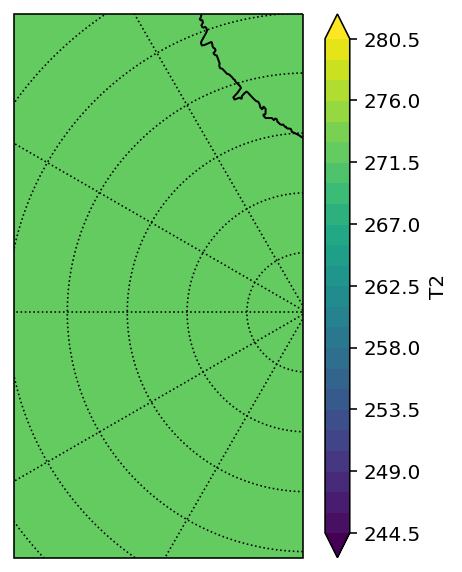

In [40]:
## THIS NEEDS cartopy 0.18 but can't install it for some reason...

import shapely.geometry as sgeom
import cartopy.crs as ccrs


box = sgeom.box(minx=35, maxx=175, miny=-80, maxy=-88.5)
x0, y0, x1, y1 = box.bounds
myproj = ccrs.SouthPolarStereo(central_longitude=180)
# myproj = ccrs.Orthographic()

plt.figure(figsize=(4, 5), facecolor='white', dpi=144)
ax = plt.axes(projection=myproj)
ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())  
ax.coastlines('50m')
# ax.stock_img()

# pcm1 = ax.pcolormesh(da.west_east, ds.south_north, da.mean(dim='Time'),\
#                     vmin=268, vmax=275,\
#                     transform=ccrs.PlateCarree())#, cmap=plt.get_cmap("BuPu")
## Alternative
kwargs = dict(ax=ax,
              x='west_east', y='south_north',
              transform=ccrs.PlateCarree())#, vmin=270, vmax=275)
pcm1 = da.mean(dim='Time').plot.contourf(levels=31, robust=True,  **kwargs)


# # c = plt.colorbar(orientation='vertical', shrink=0.4, pad=0.10)
# cb1 = plt.colorbar(pcm1, ax=ax, label=r'Surface Heat Flux $[W {m^{-2}}]$', \
#                    orientation='horizontal', extend='both', \
#                   shrink=0.9, pad=0.01)
# ax.plot(ds.lon[si, sj], ds.lat[si, sj], 'ko', markersize=3, transform=ccrs.PlateCarree())
# ax.plot(ds.lon[ai, aj], ds.lat[ai, aj], 'ko', markersize=3, transform=ccrs.PlateCarree())
# # ax.plot(LON[ssj, ssi], LAT[ssj, ssi], 'ko', markersize=2, transform=ccrs.PlateCarree())

ax.gridlines(color="black", linestyle="dotted")
# plt.suptitle('LH')
# plt.tight_layout()
# plt.savefig('figs/mapplot_TNB_Fsfc_mean.png')
plt.show()

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


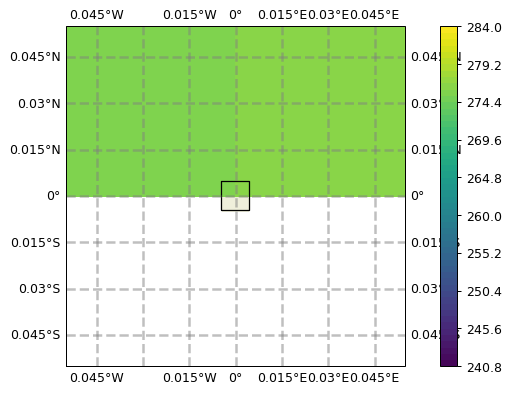

In [43]:
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10,5), dpi= 90)

# here is where you specify what projection you want to use
ax = plt.axes(projection=ccrs.PlateCarree())

# here is here you tell Cartopy that the projection
# of your 'x' and 'y' are geographic (lons and lats)
# and that you want to transform those lats and lons
# into 'x' and 'y' in the projection
plt.contourf(da.west_east, ds.south_north, da.mean(dim='Time'), 60,
             transform=ccrs.PlateCarree());
# kwargs = dict(ax=ax,
#               x='west_east', y='south_north',
#               transform=ccrs.PlateCarree())#, vmin=270, vmax=275)
# pcm1 = da.mean(dim='Time').plot.contourf(levels=31, robust=True,  **kwargs)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--');
ax.coastlines()
ax.add_feature(cfeature.LAND)

plt.colorbar()

### SALEM

In [ ]:
import salem

### Loop through list of URLs

In [ ]:
url = 'gs://' + NCs[0]# + '#mode=bytes'
with  fsspec.open(url, mode='rb')  as openfile:  
    ds2 = xr.open_dataset(openfile, engine='h5netcdf', 
                         chunks={'south_north': 200, 'west_east': 200, 'Time': -1}).load()
    print(ds.variables['XTIME'].values)
    
for i in tqdm(range(1, len(NCs))):  
    url = 'gs://' + NCs[i]# + '#mode=bytes'
    with  fsspec.open(url, mode='rb')  as openfile:  
        temp = xr.open_dataset(openfile, engine='h5netcdf', 
                               chunks={'south_north': 200, 'west_east': 200, 'Time': -1}).load()
        print(temp.variables['XTIME'].values)
        
#     ds2 = xr.concat([ds,temp],'Time')
    
# print(ds.nbytes / 1e9)
# print(ds.XTIME.values)
# ds

## Test write to zarr

In [ ]:
outdir = os.path.join(gcsdir, ampsdir, amps_ver, domain, 'zarr-cf/')
# fs.glob(outdir)
fs.ls(outdir)

In [ ]:
import json

with open('secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)

amps_mapper = fsspec.get_mapper(outdir + 'test_20161225-cf.zarr', mode='ab',
                            token=token)
# ds.to_zarr(amps_mapper, mode='w');

## Close your cluster, be a good denizen.

In [69]:
cluster.shutdown()